In [24]:
#!pip install soundfile
#!pip install pypesq
#!pip install pystoi
#!pip install torchmetrics[audio]
import os
import soundfile as sf
import torch
import matplotlib.pyplot as plt
import numpy as np 
import scipy
import scipy.signal as ss
from torch.utils.data import DataLoader, Dataset
import IPython.display as ipd
import torch.nn as nn
from pystoi import stoi
import numpy.random




# PROJET : Audio Denoising

## Elèves
>(Léa, Bohbot)
>(Valentine, Tosel)

## Consignes
Pour ce projet vous avez :

Pour le train 
- Un dossier contenant des fichiers d'enregistrements de voix sans bruit (audio/voice_origin/train)
- Un dossier contenant des fichiers d'enregistrements de voix avec une ambiance de rue en arrière-plan (audio/denoising/train)
La correspondance entre un enregistrement avec ambiance et l'enregistrement parfait de la voix se fait via le nom des fichiers. 

Pour l'ensemble de test vous avez deux ensembles de fichiers similaires. 

Dans audio/voice_origin et audio/denoising vous avec un dossier train_small de petite taille que vous pouvez télécharger rapidement pour faire des essai. 

L'objectif est d'estimer à partir du signal bruité le signal de voix. 

Les signaux ont un SNR (Signal to Noise Ratio) compris entre 0 et 20 dB. 

Vous pouvez au choix travailler 
- sur le spectrogramme par exemple en vous des approches par masquage présentés dans le cours 08 et en estimant les masques avec un réseau **Seq2Seq** de votre choix ou un **UNet** (cf A. Jansson et Al., SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORK, ISMIR 2017 )
- directement sur la forme d'onde  : 
   - cf D. Stoller  et Al., **WAVE-U-NET: A MULTI-SCALE NEURAL NETWORK FOR END-TO-END AUDIO SOURCE SEPARATION**, ISMIR 2018
   - les approches **TAS NEt** : Y. Luo et Al., TaSNet: Time-Domain Audio Separation Network for Real-Time, Single-Channel Speech Separation, ICASSP 2018 ou Y. Luo et Al.,  Conv-tasnet: surpassing ideal time–frequency magnitude masking for speech separation. IEEE/ACM Transactions on Audio, Speech, and Language Processing, 2019.


Libre à vous de choisir la **fonction de perte** utilisée dans l’entraînement et adaptée au format des données que vous utiliserez en entrée du réseau de neurones. 

**Pour l'évaluation des performances sur l'ensemble de test, outre la fonction de perte vous vous intéresserez au PESQ et au STOI des voix estimées.**  


# A propos de ce notebook 

> Ce notebook reprend les classes implémenté dans le github que nous avons créé pour ce projet.
> Les modèles calculés ont été entrainés sur GPU lorsque nous en avons eu la possibilité. 

## Chargement des données

>Nous avons trois jeux de données "train" , "train_small" et "test". On visualise dans un premier temps les données de "train_small".
>Ce sont des fichiers .wav, pour lesquels on stocke le signal et la fréquence correspondante dans des tableaux numpy.
>Nous utiliserons la librairie librosa de Python pour manipuler et visualiser les données.

In [2]:
small_data_path = r"../audio_files/noisy_signals/train_small"
clean_small_data_path = r"../audio_files/clean_signals/train_small"

In [3]:
small_signals = []
small_f_echs = []
small_file_names = []

for file in os.listdir(small_data_path):
    noisy_filepath = os.path.join(small_data_path, file)
    clean_filepath = os.path.join(clean_small_data_path, file)
    noisy_signal, sr = sf.read(noisy_filepath)
    clean_signal, _ = sf.read(clean_filepath)
    small_signals.append([noisy_signal, clean_signal])
    small_f_echs.append(sr)
    small_file_names.append(file)


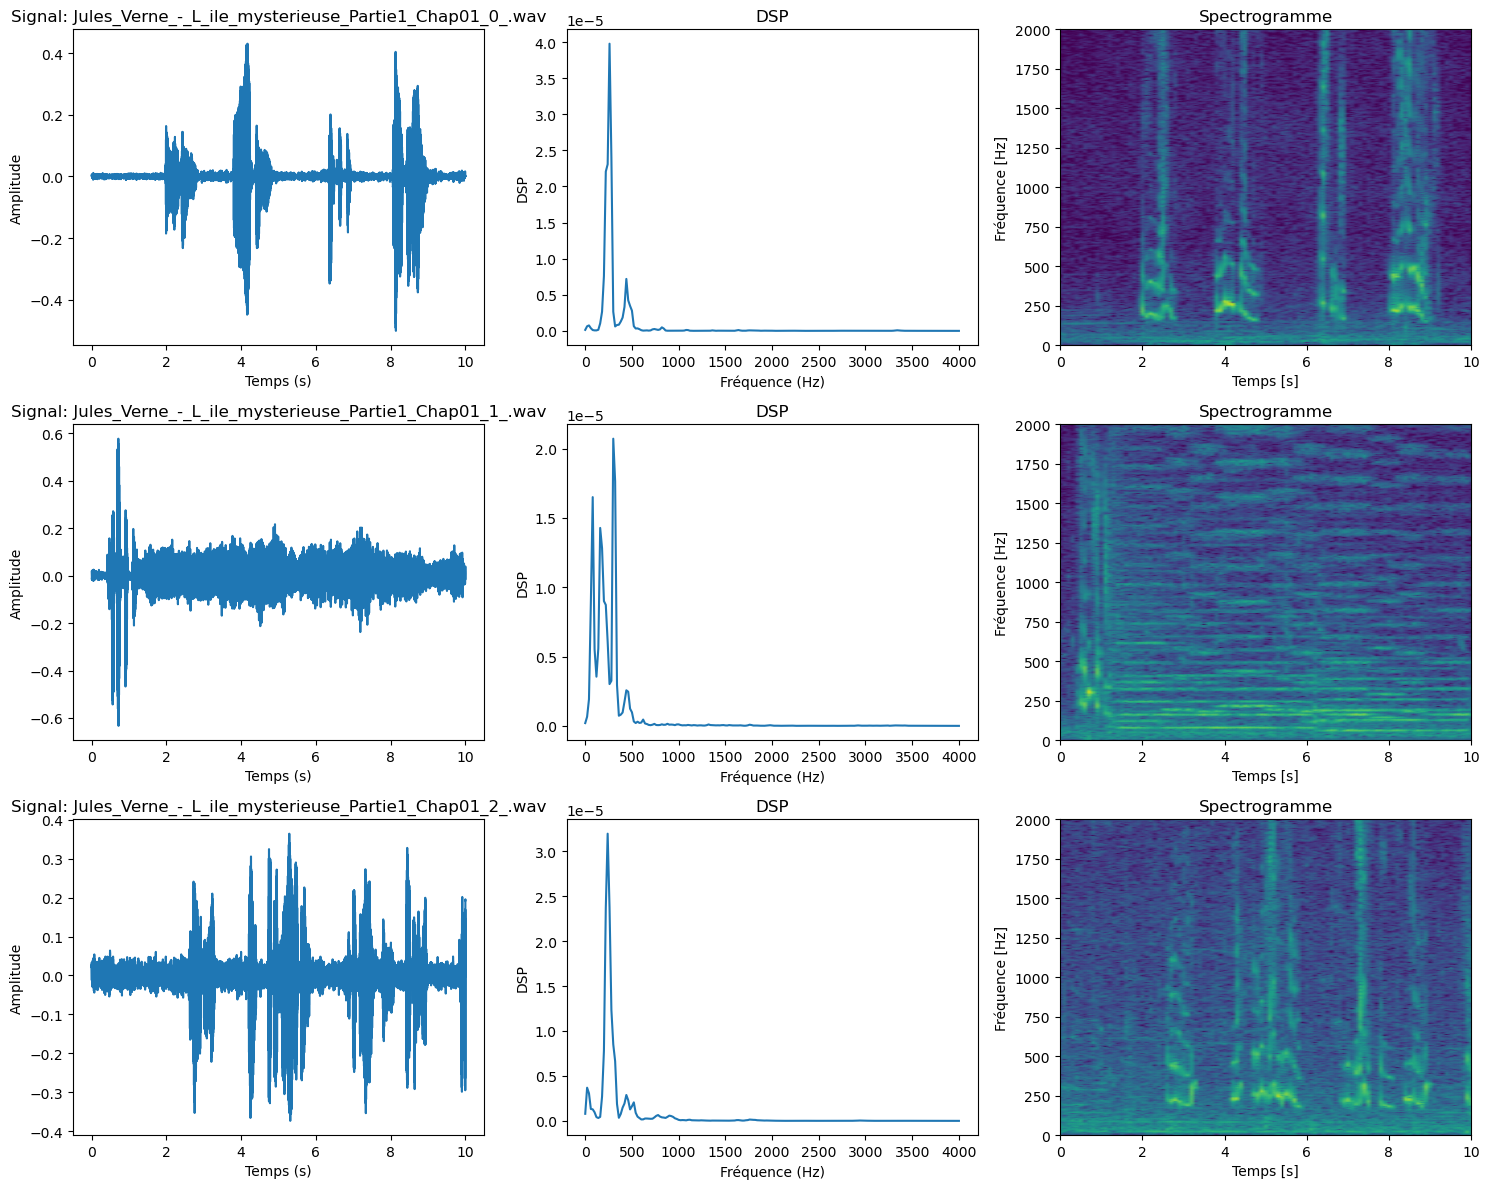

In [4]:
## SIGNAUX BRUITES
n = 3
fig, axes = plt.subplots(n, 3, figsize=(15, 4 * n))
for i in range(n):
    fe=small_f_echs[i]
    x = small_signals[i][0]
    t = np.arange(0,len(x)/fe,1/fe)

    #Signal
    axes[i, 0].plot(t,x)
    axes[i, 0].set_title(f"Signal: {small_file_names[i]}")
    axes[i, 0].set_xlabel("Temps (s)")
    axes[i, 0].set_ylabel("Amplitude")
    
    #DSP
    ff, dsp = scipy.signal.welch(x, fs=fe, nperseg=fe//20)
    axes[i, 1].plot(ff, dsp)
    axes[i, 1].set_title('DSP')
    axes[i, 1].set_xlabel('Fréquence (Hz)')
    axes[i, 1].set_ylabel('DSP')

    #Spectrogramme
    duree_segment= 0.2 # s
    nperseg= int(duree_segment *fe)
    f, t, Zxx = scipy.signal.stft(x, fe, nperseg=nperseg, noverlap=nperseg//2)
    axes[i, 2].pcolormesh(t, f, 20*np.log10(np.abs(Zxx)), vmax = -10,  vmin=-100,shading='gouraud')
    axes[i, 2].set_title('Spectrogramme')
    axes[i, 2].set_ylabel('Fréquence [Hz]')
    axes[i, 2].set_xlabel('Temps [s]')
    axes[i, 2].set_ylim([0,2000])

plt.tight_layout()
plt.show()


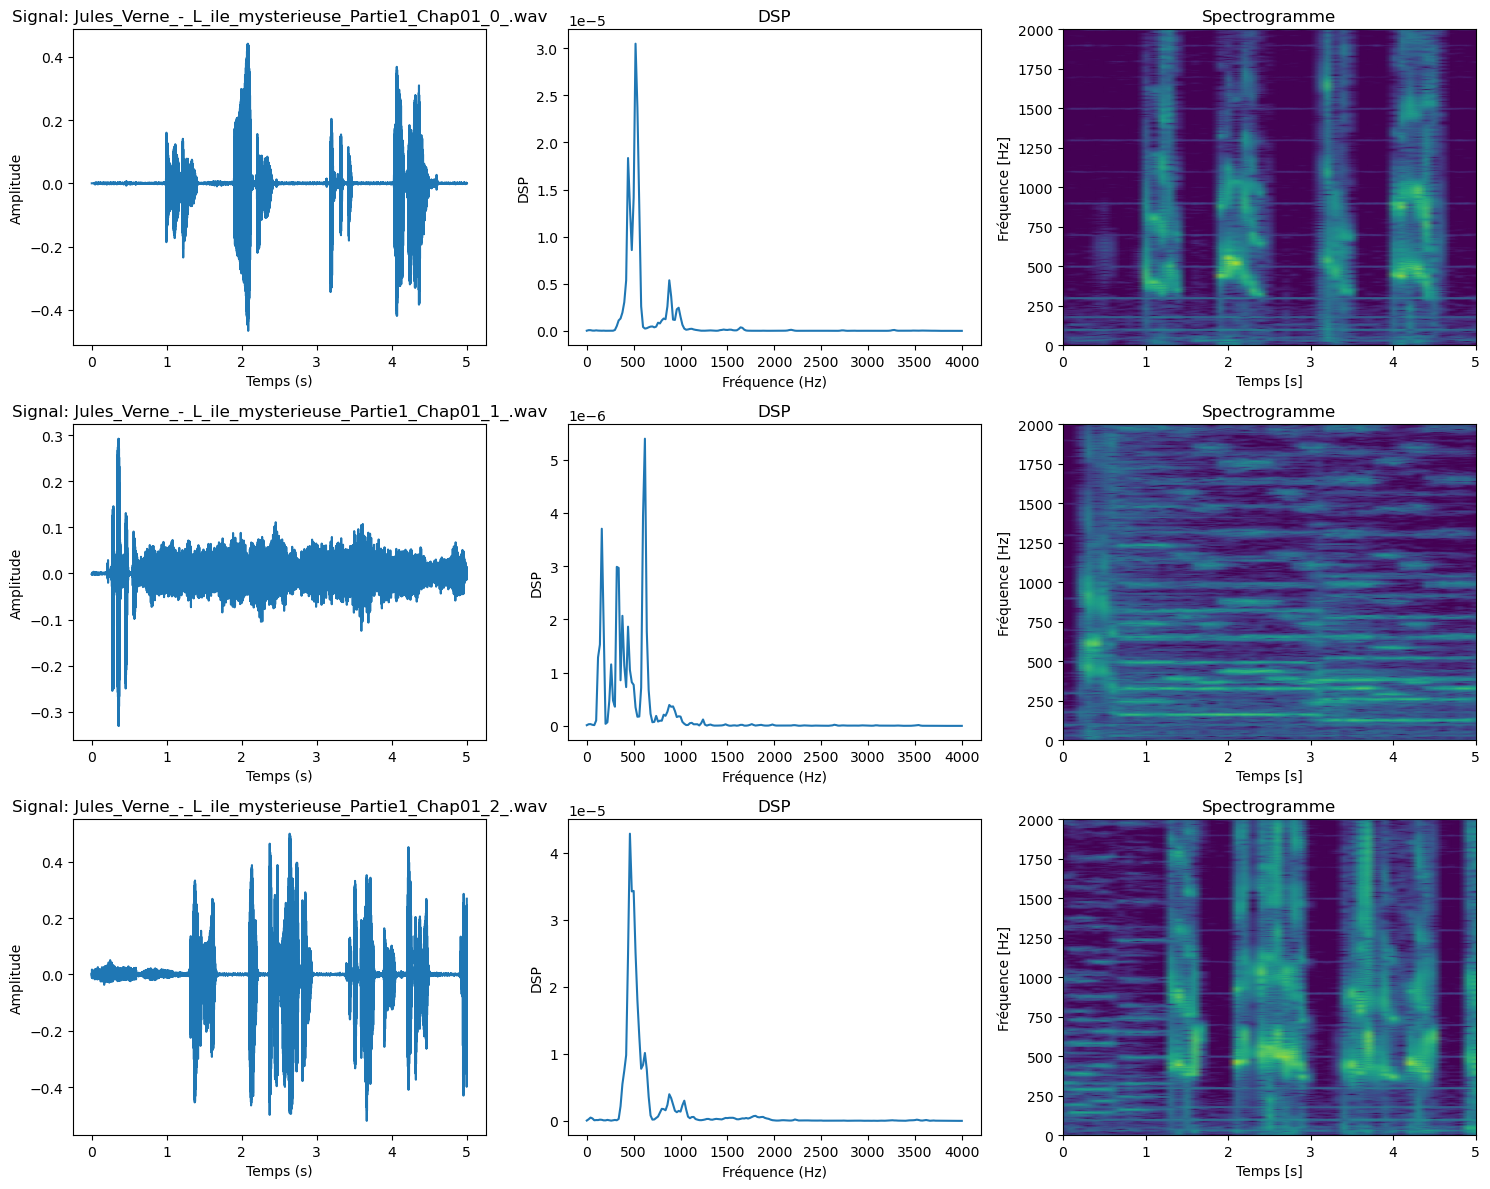

In [5]:
#SIGNAUX SANS BRUIT
fig, axes = plt.subplots(n, 3, figsize=(15, 4 * n))
for i in range(n):
    fe=small_f_echs[i]
    x = small_signals[i][1]
    t = np.arange(0,len(x)/fe,1/fe)

    #Signal
    axes[i, 0].plot(t,x)
    axes[i, 0].set_title(f"Signal: {small_file_names[i]}")
    axes[i, 0].set_xlabel("Temps (s)")
    axes[i, 0].set_ylabel("Amplitude")
    
    #DSP
    ff, dsp = scipy.signal.welch(x, fs=fe, nperseg=fe//20)
    axes[i, 1].plot(ff, dsp)
    axes[i, 1].set_title('DSP')
    axes[i, 1].set_xlabel('Fréquence (Hz)')
    axes[i, 1].set_ylabel('DSP')

    #Spectrogramme
    duree_segment= 0.2 # s
    nperseg= int(duree_segment *fe)
    f, t, Zxx = scipy.signal.stft(x, fe, nperseg=nperseg, noverlap=nperseg//2)
    axes[i, 2].pcolormesh(t, f, 20*np.log10(np.abs(Zxx)), vmax = -10,  vmin=-100,shading='gouraud')
    axes[i, 2].set_title('Spectrogramme')
    axes[i, 2].set_ylabel('Fréquence [Hz]')
    axes[i, 2].set_xlabel('Temps [s]')
    axes[i, 2].set_ylim([0,2000])

plt.tight_layout()
plt.show()

>Les signaux les plus bruités se reconnaissent visuellement par un spectrogramme bruité, et une absence de moment de "silence"
>(d'amplitude basse) dans le signal audio. L'impact sur la DSP n'est en revanche pas très visible.
>
>L'aspect étrange du deuxième signal vient du fait qu'il n'y a pas de voix mais une musique dans une grande partie de l'audio. 

## Débruitage très grossier : filtre de Wiener


Audio 4
Version originale


Version débruitée


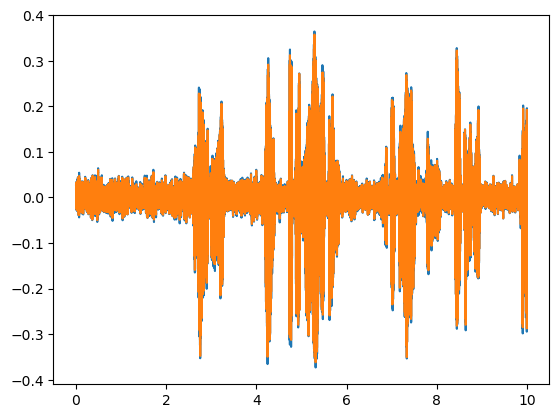

In [6]:
small_wiener_signals = []
for i in range(n) :
    signal = small_signals[i][0]
    denoised = scipy.signal.wiener(signal)
    small_wiener_signals.append(denoised)
print("Audio 4")
print("Version originale")
ipd.display(ipd.Audio(small_signals[2][0], rate=small_f_echs[2]))

print("Version débruitée")
ipd.display(ipd.Audio(small_wiener_signals[2], rate=small_f_echs[2]))

fe=small_f_echs[2]
x = small_signals[2][0]
t = np.arange(0,len(x)/fe,1/fe)
plt.plot(t,x)
plt.plot(t, small_wiener_signals[2])
plt.show()


>A l'écoute, le débruitage de Wiener implémenté par scipy n'a quasiment pas d'effet.

## Débruitage avancé

>Dans la suite du projet, nous avons implémenté un réseau **Res-Unet**, devant permettre le débruitage du spectogramme. 
>Le réseau est conçu comme suit :

## ResUNet

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Identity mapping (shortcut connection)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)  # Add the residual (skip) connection
        out = self.relu(out)
        return out

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.res_block = ResidualBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.res_block(x)
        skip = x  # skip connection for the decoder
        x = self.pool(x)
        return x, skip

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.res_block = ResidualBlock(out_channels * 2, out_channels)  # Concatenate skip connection

    def forward(self, x, skip):
        x = self.upconv(x)  # Perform upsampling
        if x.shape[2:] != skip.shape[2:]:  # Check for mismatched spatial dimensions
            x = torch.nn.functional.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)  # Concatenate along channel axis
        x = self.res_block(x)  # Pass through residual block
        return x


class ResUnet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResUnet, self).__init__()
        #Sigmoid
        self.sigmo = nn.Sigmoid()
        # Encoder
        self.encoder1 = EncoderBlock(in_channels, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)

        # Bottleneck
        self.bottleneck = ResidualBlock(512, 1024)

        # Decoder
        self.decoder4 = DecoderBlock(1024, 512)
        self.decoder3 = DecoderBlock(512, 256)
        self.decoder2 = DecoderBlock(256, 128)
        self.decoder1 = DecoderBlock(128, 64)

        # Final layer to output the result
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        enc1, skip1 = self.encoder1(x)
        enc2, skip2 = self.encoder2(enc1)
        enc3, skip3 = self.encoder3(enc2)
        enc4, skip4 = self.encoder4(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc4)

        # Decoder path
        dec4 = self.decoder4(bottleneck, skip4)
        dec3 = self.decoder3(dec4, skip3)
        dec2 = self.decoder2(dec3, skip2)
        dec1 = self.decoder1(dec2, skip1)
        
        # Final convolution and sigmoide
        out = self.sigmo(self.final_conv(dec1))
        return out


>On travaille sur les spectogrammes des signaux aux amplitudes normalisées dans [0,1]
>On travaille avec l'optimiseur Adam (et les paramètres par défaut, soit un learning rate de 10e-3), et avec une loss (R)MSE ou L1 sur le log des amplitudes (avec un terme epsilon=10e-7) du spectogramme.

>La convergence est très lente, et nous n'avons pas de modèles entrainés de façon complètement satisfaisante. Montrons les résultats obtenus avec deux modèles partiellement entraînés.

## Chargement de deux modèles entraînés

> On charge ici le modèle qui a été entrainé précédement (en dehors du notebook)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
m_1_path = "../checkpoints/resunet_model01.pt"
modele_1 = ResUnet(1,1).to(device)
modele_1.load_state_dict(torch.load(m_1_path, map_location=device))

C:\Users\valen\AppData\Local\Temp\ipykernel_11068\2345479018.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modele_1.load_state_dict(torch.load(m_1_path, map_location=d

<All keys matched successfully>

## Class dataset et pipeline d'entrainement

### Class dataset

In [16]:
class SpectrogramDataset(Dataset): #suppose qu'on met les spectrogrammes en entrée
    def __init__(self, path_to_signals, path_to_names):
        self.spectos = np.load(path_to_signals)
        self.names = np.load(path_to_names)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, i):
        clean_noisy = (self.spectos[i])
        s_clean = torch.unsqueeze(torch.tensor((clean_noisy[1])),0) #Tenseur 2D : temps x frequence sur le specto [T,C] = [2001, 41] normalement 
        s_noisy = torch.unsqueeze(torch.tensor((clean_noisy[0])),0)  #Tenseur 2D : temps x frequence sur le specto [T,C]
        #print(s_clean.shape)
        return s_noisy.type(torch.float), s_clean.type(torch.float)    


### Class main 

Voir main.py

# Tests et résultats

In [18]:
def model_evaluate(model, test_dataloader):
    masks = []
    with torch.no_grad():
        for noisy, clean in test_dataloader:
            noisy, clean = noisy.to(device), clean.to(device)
            output = model(noisy).cpu()
            mask = np.array((output.squeeze(0)).squeeze(0))
            masks.append(mask)
    return((masks))  # Save with dtype=object  # Save masks to file


def masks_to_signals(masks, spectos, noisy_phases ):
    signals = []
    for i in range(len(masks)):
      new_specto = masks[i]*spectos[i][0]*np.exp(1j*noisy_phases[i])
      t, signal = ss.istft(new_specto)
      signals.append(signal)
    return(signals)

def compute_stoi(denoised1, denoised2, signals, fs = 8000):
    stoi1 = []
    stoi2 = []
    stoi0 = []
    for i in range(len(denoised1)):
        signal1 = (denoised1[i])/np.max(np.abs(denoised1[i]))
        signal2 = (denoised2[i])/np.max(np.abs(denoised2[i]))
        noisy = signals[i][0]/np.max(np.abs(signals[i][0]))
        clean = signals[i][1]/np.max(np.abs(signals[i][1]))
        stoi0.append(stoi(clean, noisy, fs, extended=False))
        stoi1.append(stoi(clean, signal1, fs, extended=False))
        stoi2.append(stoi(clean, signal2, fs, extended=False))
    print("STOI moyen (debruité 1 et 2, bruité) :", np.mean(np.array(stoi1)),np.mean(np.array(stoi2)),np.mean(np.array(stoi0)))
    return(stoi0, stoi1, stoi2)

def compute_pesq(denoised1, denoised2, signals, fs = 8000):
    pesq1 = []
    pesq2 = []
    pesq0 = []
    for i in range(len(denoised1)):
        signal1 = (denoised1[i])/np.max(np.abs(denoised1[i]))
        signal2 = (denoised2[i])/np.max(np.abs(denoised2[i]))
        noisy = signals[i][0]/np.max(np.abs(signals[i][0]))
        clean = signals[i][1]/np.max(np.abs(signals[i][1]))
        pesq0.append(pesq(fs, clean, noisy, 'nb'))
        pesq1.append(pesq(fs, clean, signal1, 'nb'))
        pesq2.append(pesq(fs, clean, signal2, 'nb'))
    print("PESQ moyen (debruité 1 et 2, bruité) :", np.mean(np.array(pesq1)),np.mean(np.array(pesq2)),np.mean(np.array(pesq0)))
    return(pesq0, pesq1, pesq2)
    

def denoised_signal_display(denoised1, denoised2, signals, names, number=10, s_r = 8000) :
    """ Input : 
    denoised1, denoised2 = arrays of denoised signals (with 2 models)
    signals = array of [noisy signal, clean signal]
    names = array of signals names
    number = number of signals to convert (if =0, all the signals)
    s_r = sampling rate

    Display the audio
    """
    if number==0 : number = len(names)
    indices = numpy.random.choice(len(names),number)
    for i in indices:
        file_name = names[i]
        signal = (denoised1[i])/np.max(np.abs(denoised1[i]))
        signal2 = (denoised2[i])/np.max(np.abs(denoised2[i]))
        noisy = signals[i][0]/np.max(np.abs(signals[i][0]))
        clean = signals[i][1]/np.max(np.abs(signals[i][1]))
        

        print(file_name, i, "Denoised 1, 2, noisy, clean")
        ipd.display(ipd.Audio(signal, rate=s_r))
        ipd.display(ipd.Audio(signal2, rate=s_r))
        ipd.display(ipd.Audio(noisy, rate=s_r))
        ipd.display(ipd.Audio(clean, rate=s_r))
        
        t = np.arange(0,len(signal)/s_r,1/s_r)
        
        plt.plot(t, noisy, label = 'Noisy', alpha=0.1)
        plt.plot(t,signal, label='Denoised 1', alpha=0.5)
        plt.plot(t,signal2, label='Denoised 2', alpha=0.5)
        plt.plot(t, clean, label='Clean', alpha=0.3)
        plt.legend()
        plt.title(file_name)
        plt.show()
        longueur = len(noisy)

        f, t, specto_clean = ss.stft(clean, 1, nperseg=longueur//20, noverlap=longueur//40)
        _, _, specto_noisy = ss.stft(noisy, 1, nperseg=longueur//20, noverlap=longueur//40)
        _, _, specto_denoised = ss.stft(signal, 1, nperseg=longueur//20, noverlap=longueur//40)
        _, _, specto_denoised2 = ss.stft(signal2, 1, nperseg=longueur//20, noverlap=longueur//40)
        fig, axes = plt.subplots(1, 4, figsize=(16, 5))

        axes[0].pcolormesh(t, f, 20*np.log10(np.abs(specto_denoised)), vmax = -10,  vmin=-100,shading='gouraud')
        axes[0].set_title('Spectrogramme denoised (1)')
        axes[1].pcolormesh(t, f, 20*np.log10(np.abs(specto_denoised2)), vmax = -10,  vmin=-100,shading='gouraud')
        axes[1].set_title('Spectrogramme denoised (2)')
        axes[2].pcolormesh(t, f, 20*np.log10(np.abs(specto_noisy)), vmax = -10,  vmin=-100,shading='gouraud')
        axes[2].set_title('Spectrogramme noisy')
        
        axes[3].pcolormesh(t, f, 20*np.log10(np.abs(specto_clean)), vmax = -10,  vmin=-100,shading='gouraud')
        axes[3].set_title('Spectrogramme clean')
        
        plt.tight_layout()
        plt.show()

In [20]:
path_test = "../data/global/test_spectos.npy"
path_test_names = "../data/global/test_names.npy"
path_test_signals = "../data/global/test_signals.npy"
path_test_phases = "../data/global/test_phases.npy"

test_dataset = SpectrogramDataset(path_to_signals=path_test, path_to_names=path_test_names)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [21]:
masks = model_evaluate(modele_1,test_dataloader)
specto = np.load(path_test)
phases = np.load(path_test_phases)
names = np.load(path_test_names)

denoised = masks_to_signals(masks,specto,phases)

In [22]:
m_2_path = "../checkpoints/resunet_model02.pt"
#m_2_path = "./checkpoints/resunet_model.pt"
modele_2 = ResUnet(1,1).to(device)
modele_2.load_state_dict(torch.load(m_2_path, map_location=device))
masks2 = model_evaluate(modele_2,test_dataloader)
denoised2 = masks_to_signals(masks2,specto,phases)
signals = np.load(path_test_signals)

C:\Users\valen\AppData\Local\Temp\ipykernel_11068\1683754967.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modele_2.load_state_dict(torch.load(m_2_path, map_location=d

In [25]:
stoi1, stoi2, stoi_bruit = compute_stoi(denoised,denoised2,signals)

STOI moyen (debuité 1 et 2, bruité) : 0.9164274141630699 0.9148759831217257 0.9253397741805586


In [28]:
pesq1, pesq2, pesq_bruit = compute_pesq(denoised,denoised2,signals)

PESQ moyen (debuité 1 et 2, bruité) : 2.6688777441563816 2.7063549447547444 2.5578151775138154


In [34]:

def denoised_signal_display(denoised1, denoised2, signals, names, number=10, s_r=8000):
    """
    Input: 
    denoised1, denoised2 = arrays of denoised signals (from 2 models)
    signals = array of [noisy signal, clean signal]
    names = array of signal names
    number = number of signals to convert (if = 0, all signals are processed)
    s_r = sampling rate

    Displays the audio and spectrograms.
    """
    if number == 0:
        number = len(names)
    indices = np.random.choice(len(names), number, replace=False)
    
    for i in indices:
        file_name = names[i]
        signal1 = denoised1[i] / (np.max(np.abs(denoised1[i])) + 1e-8)
        signal2 = denoised2[i] / (np.max(np.abs(denoised2[i])) + 1e-8)
        noisy = signals[i][0] / (np.max(np.abs(signals[i][0])) + 1e-8)
        clean = signals[i][1] / (np.max(np.abs(signals[i][1])) + 1e-8)
        
        print(file_name, i, "Denoised 1, Denoised 2, Noisy, Clean")
        
        # Display audio
        ipd.display(ipd.Audio(signal1, rate=s_r))
        ipd.display(ipd.Audio(signal2, rate=s_r))
        ipd.display(ipd.Audio(noisy, rate=s_r))
        ipd.display(ipd.Audio(clean, rate=s_r))
        
        # Time domain plot
        t = np.arange(0, len(signal1) / s_r, 1 / s_r)
                # Time domain plots (Noisy + Denoised1, Noisy + Denoised2, Noisy + Clean)
        t = np.arange(0, len(signal1) / s_r, 1 / s_r)
        
        # Plot Noisy + Denoised 1
        plt.figure(figsize=(12, 1))
        plt.plot(t, noisy, label='Noisy', alpha=0.5, color='gray')
        plt.plot(t, signal1, label='Denoised 1', alpha=0.8, color='blue')
        plt.title(f"{file_name} - Noisy + Denoised 1")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()
        
        # Plot Noisy + Denoised 2
        plt.figure(figsize=(12, 1))
        plt.plot(t, noisy, label='Noisy', alpha=0.5, color='gray')
        plt.plot(t, signal2, label='Denoised 2', alpha=0.8, color='green')
        plt.title(f"{file_name} - Noisy + Denoised 2")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()
        
        # Plot Noisy + Clean
        plt.figure(figsize=(12, 1))
        plt.plot(t, noisy, label='Noisy', alpha=0.5, color='gray')
        plt.plot(t, clean, label='Clean', alpha=0.8, color='orange')
        plt.title(f"{file_name} - Noisy + Clean")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()
        plt.figure(figsize=(10, 5))
        plt.plot(t, noisy, label='Noisy', alpha=0.3)
        plt.plot(t, signal1, label='Denoised 1', alpha=0.7)
        plt.plot(t, signal2, label='Denoised 2', alpha=0.7)
        plt.plot(t, clean, label='Clean', alpha=0.5)
        plt.legend()
        plt.title(file_name + " - Time Domain")
        plt.show()
        
        # Compute spectrograms
        longueur = len(noisy)
        f, t, specto_noisy = ss.stft(noisy, 1, nperseg=longueur // 20, noverlap=longueur // 40)
        _, _, specto_denoised1 = ss.stft(signal1, 1, nperseg=longueur // 20, noverlap=longueur // 40)
        _, _, specto_denoised2 = ss.stft(signal2, 1, nperseg=longueur // 20, noverlap=longueur // 40)
        _, _, specto_clean = ss.stft(clean, 1, nperseg=longueur // 20, noverlap=longueur // 40)
        
        
        fig, axes = plt.subplots(1, 4, figsize=(18, 6))
        
        # Denoised 1
        #axes[0].pcolormesh(t, f, 20 * np.log10(np.abs(specto_noisy)), vmax=-10, vmin=-100, shading='gouraud')
        axes[0].pcolormesh(t, f, 20 * np.log10(np.abs(specto_denoised1)), vmax=-10, vmin=-100, alpha=0.5, shading='gouraud')
        axes[0].set_title(' Denoised 1')
        
        # Denoised 2
        #axes[1].pcolormesh(t, f, 20 * np.log10(np.abs(specto_noisy)), vmax=-10, vmin=-100, shading='gouraud')
        axes[1].pcolormesh(t, f, 20 * np.log10(np.abs(specto_denoised2)), vmax=-10, vmin=-100, alpha=0.5, shading='gouraud')
        axes[1].set_title('Denoised 2')
        
        #Noisy
        axes[2].pcolormesh(t, f, 20 * np.log10(np.abs(specto_noisy)), vmax=-10, vmin=-100, alpha=0.5, shading='gouraud')
        axes[2].set_title('Noisy')

        # Clean
        #axes[2].pcolormesh(t, f, 20 * np.log10(np.abs(specto_noisy)), vmax=-10, vmin=-100, shading='gouraud')
        axes[3].pcolormesh(t, f, 20 * np.log10(np.abs(specto_clean)), vmax=-10, vmin=-100, alpha=0.5, shading='gouraud')
        axes[3].set_title('Clean')

        
        plt.tight_layout()
        plt.show()


Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap11_7_ 376 Denoised 1, Denoised 2, Noisy, Clean


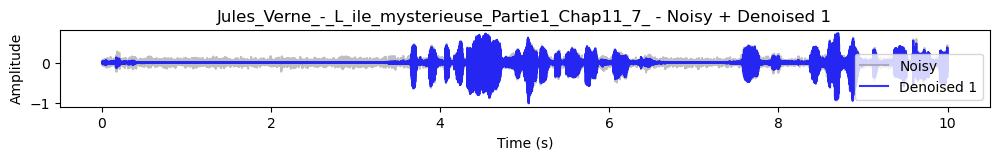

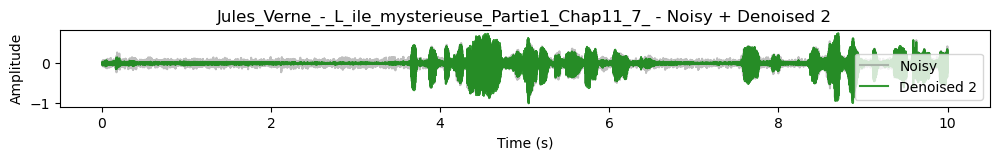

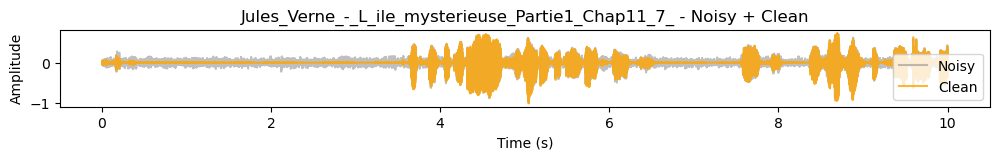

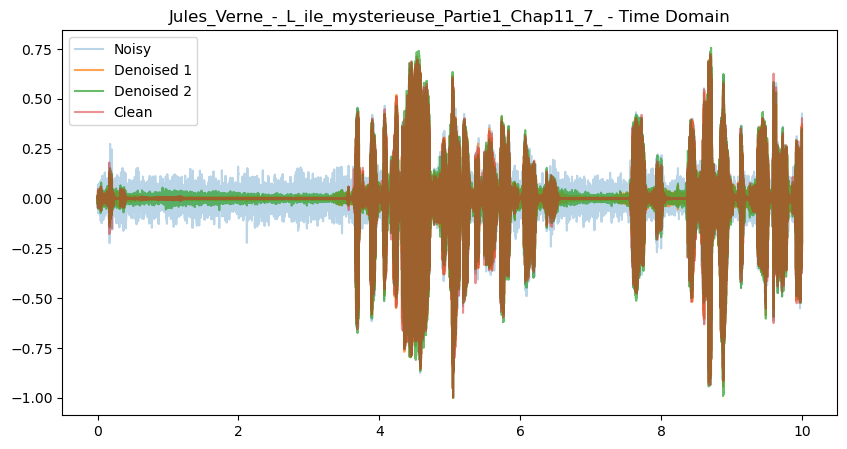

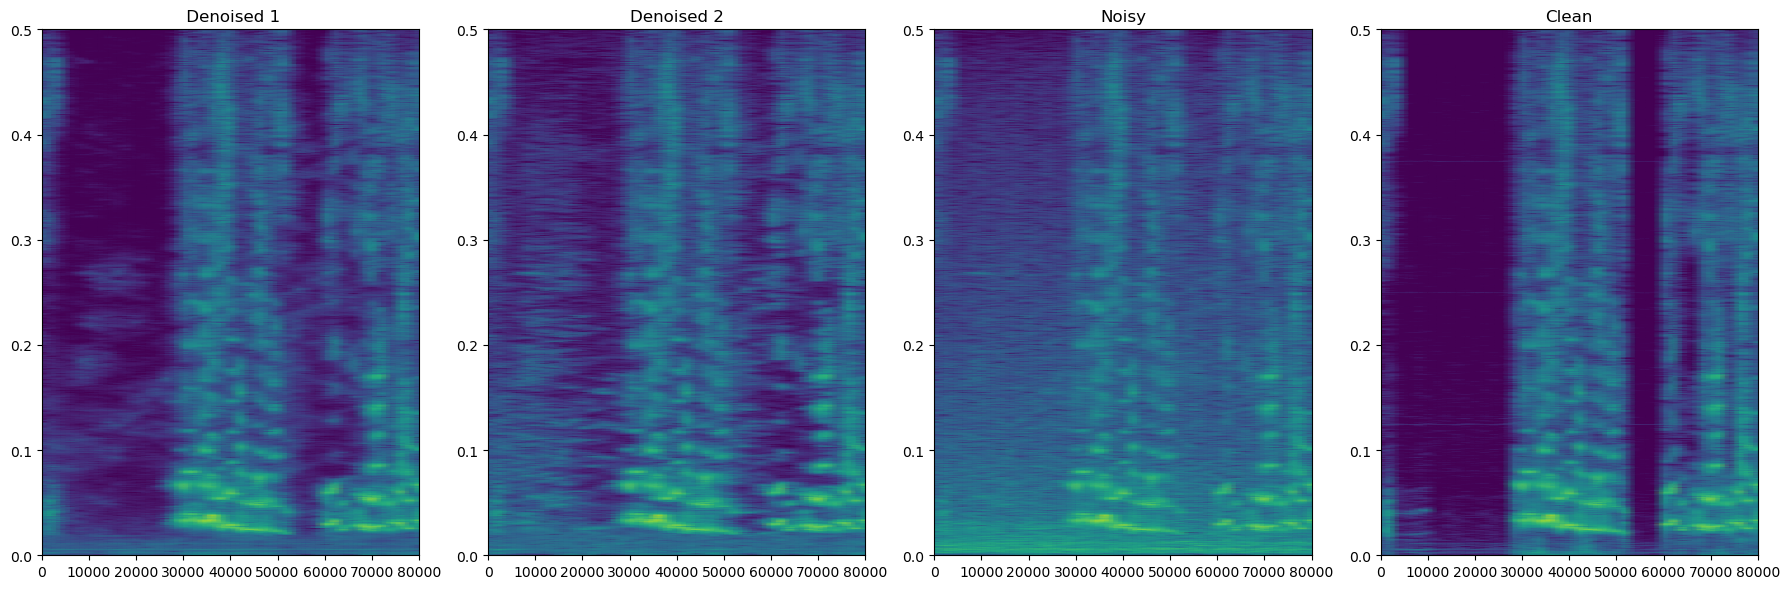

Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap17_54_ 619 Denoised 1, Denoised 2, Noisy, Clean


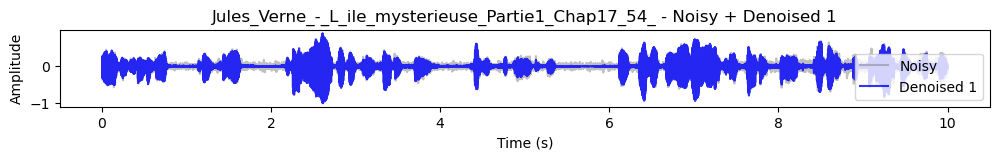

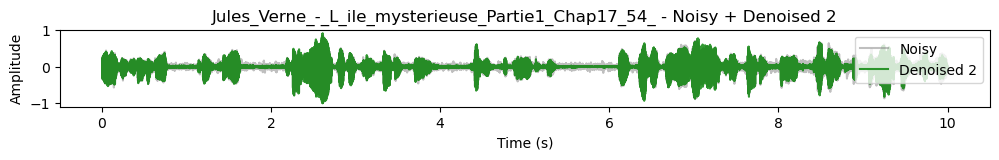

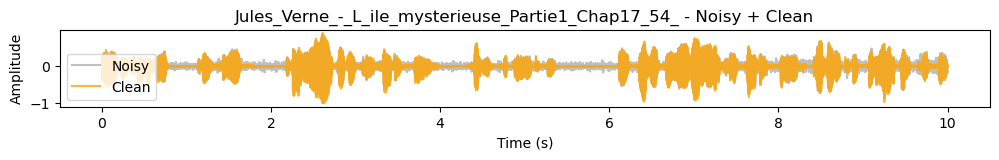

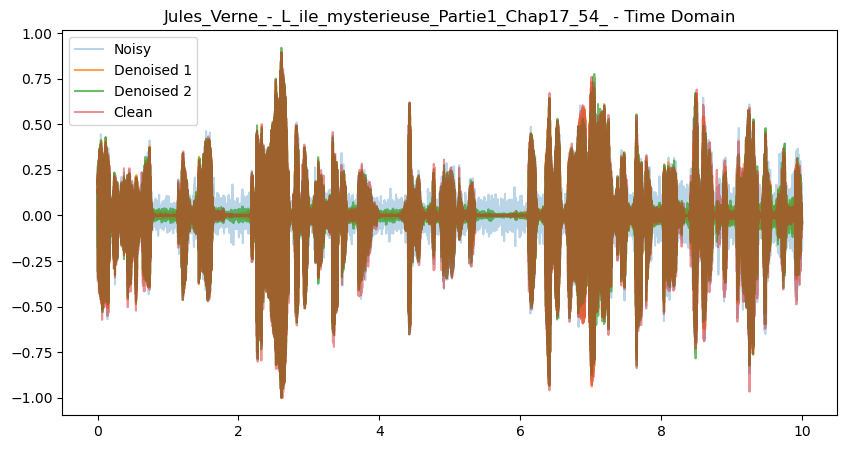

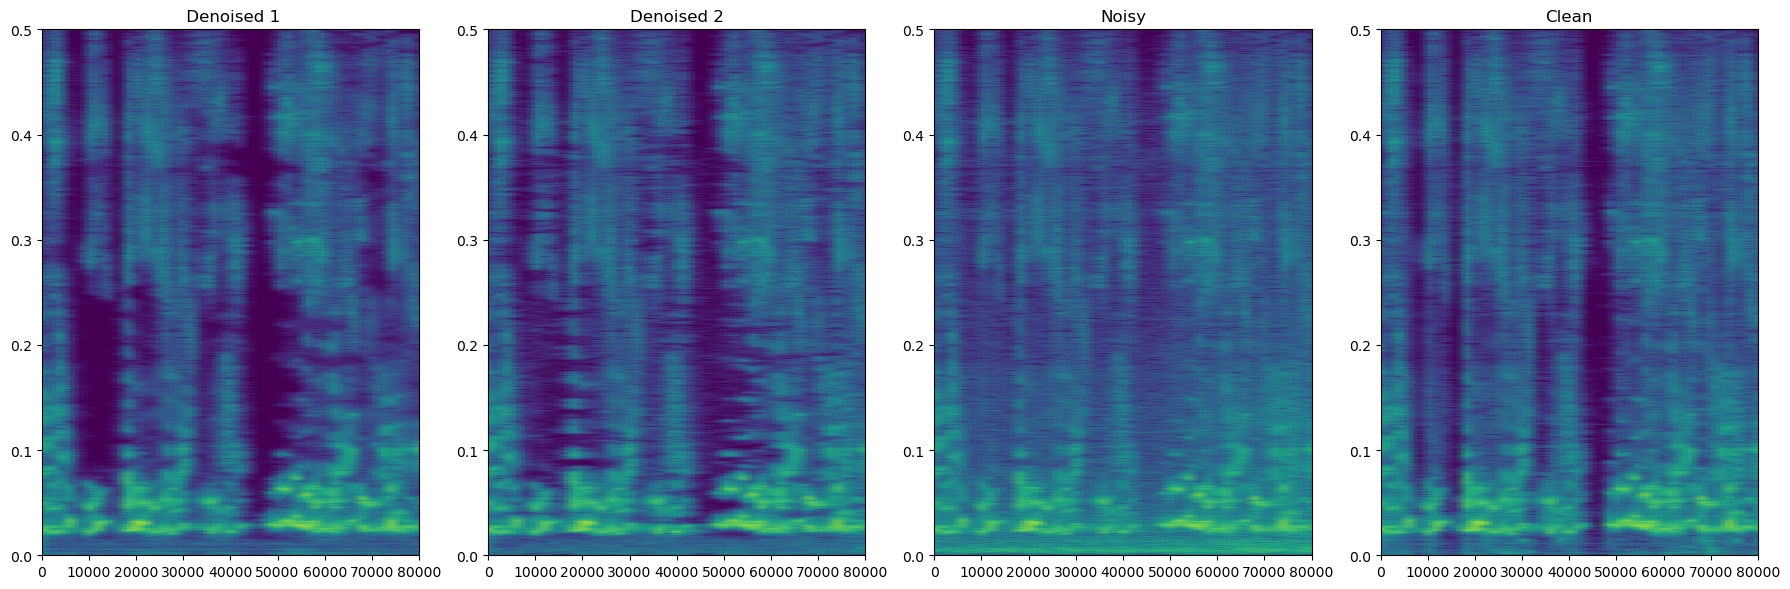

Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap11_6_ 365 Denoised 1, Denoised 2, Noisy, Clean


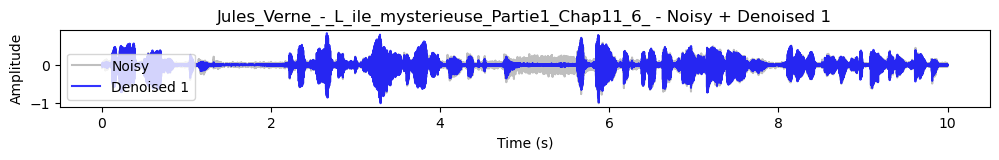

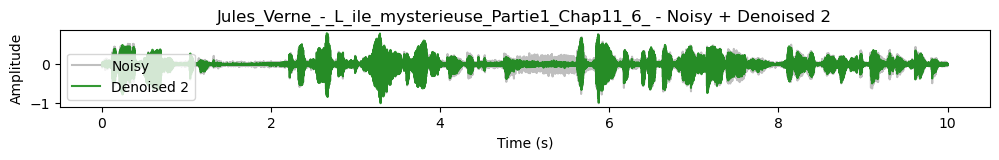

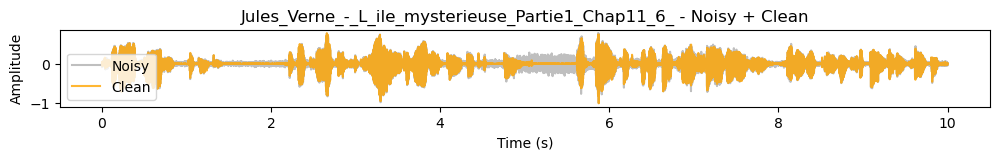

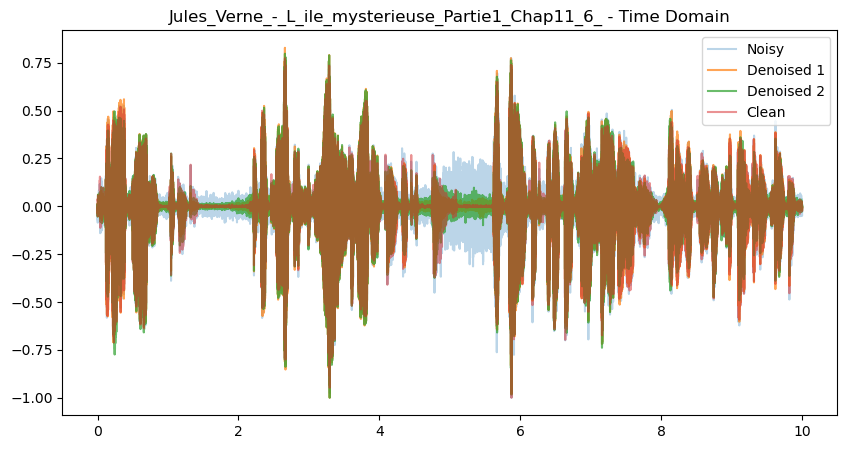

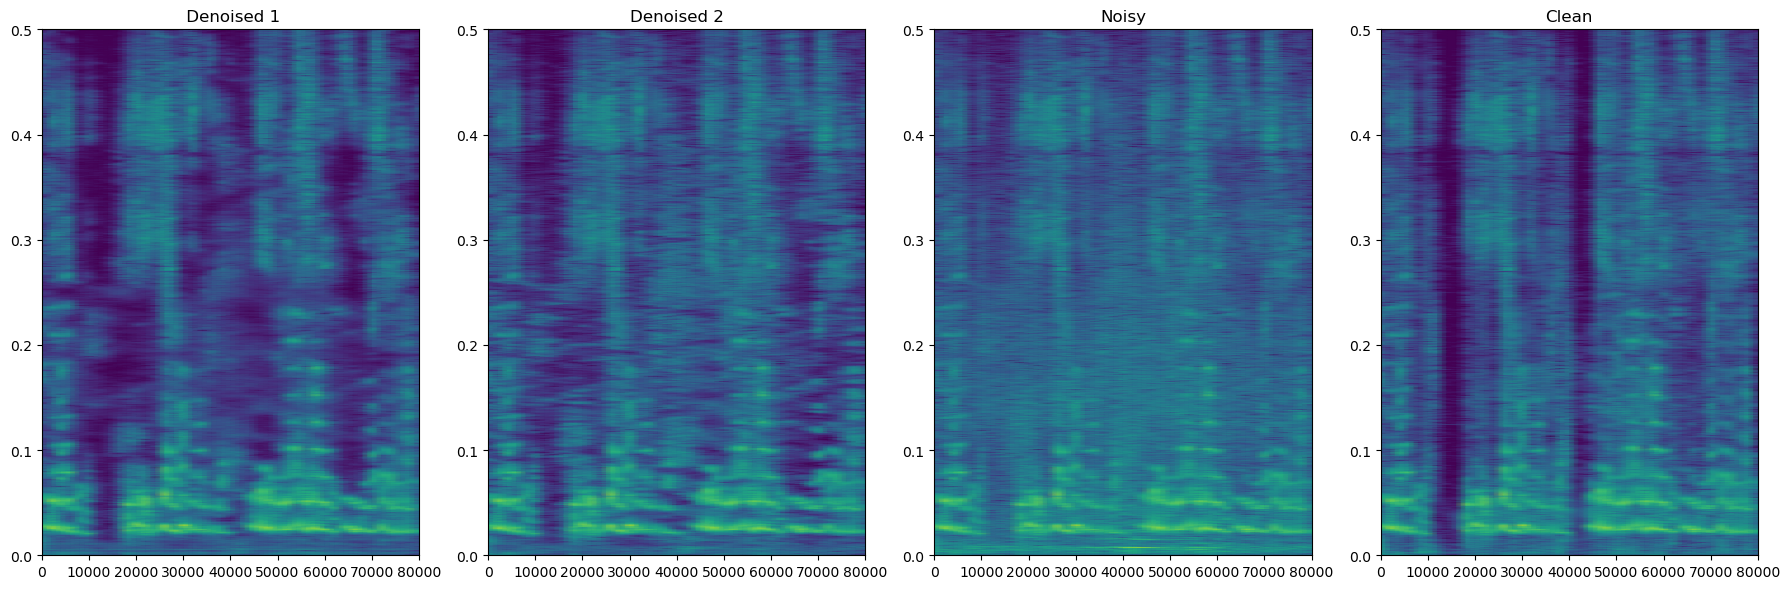

In [57]:
denoised_signal_display(denoised, denoised2, signals, names, number=3)


In [58]:
# Fonction donnant le stoi d'un signal bruité et de ses débruités, ainsi que le SNR.
snrs = np.load(r"C:\Users\valen\Documents\Travail\X\MVA\S1\ProjetTDS\dl\DL_denoising_project\data\global\test_snr.npy")
def info(i) :
    print("Stoi denoised 1, 2, signal bruité :", stoi1[i], stoi2[i], stoi_bruit[i])
    print("SNR du signal :", snrs[i])



In [63]:
info(748)


Stoi denoised 1, 2, signal bruité : 0.9367580380848265 0.9345088235250568 0.93692445996111
SNR du signal : 13.529452658160064
0.9148759831217257
